In [1]:
# Chargement des packages
import os
import re
import json
import pandas as pd
import nltk
import random
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from collections import Counter
from gensim.models import word2vec, Word2Vec
from gensim.models import KeyedVectors
from gensim.utils import tokenize

from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score


In [2]:
# Chargement des stop words
nltk.download("stopwords")

SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Importation

In [3]:
## en considérant concept par concept de façon indépendante du patient pour constituer le vocabulaire de mots de notre modèle W2V ##
## Création du fichier json d'entraînement

def json_vocab_data_from_con(PATH_DATA, json_filename):
        
        L_concepts = []

        with open(json_filename, 'w') as  data_file:
                
                for file_con in os.listdir(PATH_DATA):
                        
                        filename = PATH_DATA + file_con
                        file = open(filename, 'r')
                        #print(filename)
                        text = file.readlines() 
                        
                        for row in text:
                                
                                dict_concept = {}
                                dict_concept["concept"] = ""
                                
                                row_split = row[2:].split(" ")
                                
                                label = row_split[-1].split("=")[-1].strip()
                                dict_concept["label"] = label
                                
                                concept_split = [word for word in row_split[:len(row_split) - 2]]
                                concept = ""
                        
                                for word in concept_split:
                                        word = word.replace('"','')
                                        concept += word + " "
                                        
                                
                                dict_concept["concept"] = concept
                                L_concepts.append(dict_concept)
                        
                json.dump(L_concepts, data_file)

In [4]:
PATH_con_1 = "train_data/beth/concept/"
json_vocab_data_from_con(PATH_con_1, 'train_data/concepts.json')

In [5]:
PATH_con_2 = "train_data/partners/concept/"
json_vocab_data_from_con(PATH_con_2, 'train_data/concepts.json')

In [6]:
# Importation des datas
my_concept = pd.read_json('train_data/concepts.json')
my_concept.head()

concept        label
0                                          a workup        "test"
1                                              pain     "problem"
2  microscopic anterior cervical diskectomy at c5-6   "treatment"
3                                    hyperlipidemia     "problem"
4                               po pain medications   "treatment"

In [7]:
# Tokénization des concepts
my_concept["concept_tokens"] = [list(tokenize(concept,deacc=True,lower=True)) for concept in my_concept["concept"]]
my_concept.head()

concept        label  \
0                                          a workup        "test"   
1                                              pain     "problem"   
2  microscopic anterior cervical diskectomy at c5-6   "treatment"   
3                                    hyperlipidemia     "problem"   
4                               po pain medications   "treatment"   

                                      concept_tokens  
0                                        [a, workup]  
1                                             [pain]  
2  [microscopic, anterior, cervical, diskectomy, ...  
3                                   [hyperlipidemia]  
4                            [po, pain, medications]

## Chargement d'un modèle pré-entrainé

In [13]:
# Nom du fichier (ou chemin d'accès aux données) - Modèle avec vocabulaire bio-médical
file_name= 'pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin'

# Chargement du modèle pré-entrainé
model = KeyedVectors.load_word2vec_format(file_name, binary=True, unicode_errors="ignore")

print("Le modèle pré-entrainé a un vocabulaire qui contient {} mots distincts".format(len(model.wv.vocab)))

Le modèle pré-entrainé a un vocabulaire qui contient 2665547 mots distincts


C:\Users\Martin\AppData\Local\Temp/ipykernel_9316/3045517888.py:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  print("Le modèle pré-entrainé a un vocabulaire qui contient {} mots distincts".format(len(model.wv.vocab)))


## Création de notre modèle

In [14]:
# Initialisation du modèle

## Dim des vecteurs : 200
## Fréquence minimale des mots : 1
## Méthode utilisée : Skip-gram

my_model = Word2Vec(size=200, min_count=1,sg = 1)

C:\Users\Martin\AppData\Roaming\Python\Python38\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


In [15]:
# Création du vocabulaire 
Vocab = list(my_concept["concept_tokens"])
my_model.build_vocab(Vocab)

# Nombre de tweets utilisés dans notre corpus
total_examples = my_model.corpus_count
print("{} concepts ont été utilisés pour créer le vocabulaire de notre corpus.".format(total_examples))

# Taille du vocabulaire de notre modèle
print("Le vocabulaire comporte {} mots distincts".format(len(my_model.wv.vocab)))

6229 concepts ont été utilisés pour créer le vocabulaire de notre corpus.
Le vocabulaire comporte 3009 mots distincts


In [16]:
# Ajout du vocabulaire du modèle pré-entrainé à notre modèle
my_model.build_vocab([list(model.vocab.keys())], update=True)

# Taille du vocabulaire de notre modèle
print("Le vocabulaire comporte maintenant {} mots distincts".format(len(my_model.wv.vocab)))

Le vocabulaire comporte maintenant 2665611 mots distincts


In [17]:
# Intersection des matrices 
my_model.intersect_word2vec_format(file_name, binary=True, lockf=1.0)

In [18]:
# Sauvegarde du modèle
my_model.save("w2v_model/word2vec_model")

In [3]:
# Chargement du modèle
my_model = Word2Vec.load("w2v_model/word2vec_model")

In [9]:
# Test de similarité
my_model.wv.most_similar("cardiac")

[('myocardial', 0.7644566893577576),
 ('ventricular', 0.7020645141601562),
 ('heart', 0.694502592086792),
 ('non-cardiac', 0.6940276622772217),
 ('arrhythmias', 0.6878423094749451),
 ('noncardiac', 0.6834906339645386),
 ('cardiomyocyte', 0.6772655248641968),
 ('arrhythmia', 0.6700674295425415),
 ('left-ventricular', 0.6533072590827942),
 ('deathresuscitated', 0.6513097882270813)]

In [5]:
########## DATA pour l'entrainement ###############

# On considére les fichiers .con générés pour chaque rapport
# Pour chaque concept présent dans le fichier, nous rassemblons 
# uniquement les concepts qui sont de type problèmes car sont les plus pertinents 
# pour pouvoir identifier la pathologie du patient considéré

# Création du fichier json d'entraînement

def json_file_data_from_con(PATH_DATA_LIST, json_filename):
        
        L_concepts = []

        
        for PATH_DATA in PATH_DATA_LIST:
            with open(json_filename, 'w') as data_file:
                for file_con in os.listdir(PATH_DATA):

                        filename = PATH_DATA + file_con
                        file = open(filename, 'r')
                        text = file.readlines() 

                        dict_concept = {}
                        dict_concept["filename"] = filename
                        dict_concept["concept"] = ""

                        for row in text:
                                row_split = row[2:].split(" ")

                                label = row_split[-1].split("=")[-1].strip()
                                if label == "\"problem\"":
                                        concept_split = [word for word in row_split[:len(row_split) - 2]]
                                        concept = ""

                                        for word in concept_split:
                                                word = word.replace('"','')
                                                concept += " " + word + " "


                                        dict_concept["concept"] += concept[:-1] + "."
                        L_concepts.append(dict_concept)


                json.dump(L_concepts, data_file)
        
        

In [6]:
##### A LANCER POUR L'ENTRAINEMENT #####
PATH_con = ["train_data/beth/concept/","train_data/partners/concept/"]
json_file_data_from_con(PATH_con, 'train_data/data_con.json')

In [76]:
##### A LANCER POUR LA VALIDATION #####
PATH_con_1 = ["val_preds/concept/"]
json_file_data_from_con(PATH_con_1, 'train_data/data_con.json')

In [7]:
df_con = pd.read_json('train_data/data_con.json')

In [8]:
def clean_text(text, tokenizer, stopwords):
    """Pre-process text and generate tokens

    Args:
        text: Text to tokenize.

    Returns:
        Tokenized text.
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return tokens

In [9]:
########## CONCEPT #############
# Tokénization des concepts avec filtrage par la liste de mots vide et nettoyage par la fonction clean_text

custom_stopwords = set(stopwords.words("english") + ["news", "new", "top"])

df = df_con.copy()

# Create text column based on title, description, and content
df["tokens"] = df["concept"].apply(lambda x: clean_text(x, word_tokenize, custom_stopwords))

print(f"Original dataframe: {df_con.shape}")
print(f"Pre-processed dataframe: {df.shape}")

Original dataframe: (170, 2)
Pre-processed dataframe: (170, 3)


In [10]:
# Construction du vocabulaire du corpus de rapports médicaux
docs = df["concept"].values
tokenized_docs = df["tokens"].values
vocab = Counter()
for token in tokenized_docs:
    vocab.update(token)

In [11]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [12]:
# Vectorisation du texte sur les concepts pour chaque rapport médical
# Vecteur de taille 200
vectorized_docs = vectorize(tokenized_docs, model=my_model)
len(vectorized_docs), len(vectorized_docs[0])

(170, 200)

In [13]:
def mbkmeans_clusters(X, k, mb=500, print_silhouette_values=False):
    """Generate clusters.

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches. Defaults to 500.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

In [14]:
##### A LANCER POUR L'ENTRAINEMENT #####
# Vérifier la classe d'un patient :
nb_clusters=15
kmeans = mbkmeans_clusters(X=vectorized_docs, k=nb_clusters, print_silhouette_values=True)[0]
lst = kmeans.predict(vectorized_docs)

C:\Users\Martin\anaconda3\envs\DeepL_env\lib\site-packages\sklearn\cluster\_kmeans.py:1046: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


For n_clusters = 15
Silhouette coefficient: 0.07
Inertia:191.64457043117392
Silhouette values:
    Cluster 0: Size:2 | Avg:1.00 | Min:1.00 | Max: 1.00
    Cluster 3: Size:2 | Avg:1.00 | Min:1.00 | Max: 1.00
    Cluster 13: Size:33 | Avg:0.21 | Min:0.04 | Max: 0.32
    Cluster 12: Size:7 | Avg:0.10 | Min:-0.03 | Max: 0.23
    Cluster 2: Size:5 | Avg:0.05 | Min:-0.07 | Max: 0.13
    Cluster 4: Size:34 | Avg:0.01 | Min:-0.17 | Max: 0.11
    Cluster 1: Size:43 | Avg:0.00 | Min:-0.17 | Max: 0.08
    Cluster 7: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 8: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 9: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 10: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 11: Size:1 | Avg:0.00 | Min:0.00 | Max: 0.00
    Cluster 6: Size:4 | Avg:-0.01 | Min:-0.14 | Max: 0.08
    Cluster 5: Size:33 | Avg:-0.02 | Min:-0.15 | Max: 0.06
    Cluster 14: Size:2 | Avg:-0.07 | Min:-0.22 | Max: 0.07


In [84]:
##### A LANCER POUR LA VALIDATION #####
# prédiction sur les données de validation
lst_val = kmeans.predict(vectorized_docs)

In [85]:
lst_val
unique, counts = np.unique(lst_val, return_counts=True)
dict(zip(unique, counts))

{0: 3, 1: 18, 2: 33, 4: 2, 7: 1, 8: 2, 9: 19, 11: 2, 13: 9, 14: 39}

In [89]:
# Exemple Cluster 13 sur le problème cardiaque
result = np.where(lst_val == 13)
print(result)
for i in result[0] :
    print(df_con.loc[i,"filename"].split('/')[-1])

(array([ 38,  53,  71,  91,  98, 104, 107, 110, 113], dtype=int64),)
0158.con
0202.con
0273.con
0354.con
0377.con
0394.con
0402.con
0410.con
0424.con


Top terms per cluster (based on centroids):

Cluster 0


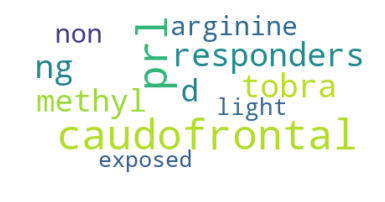


Cluster 1


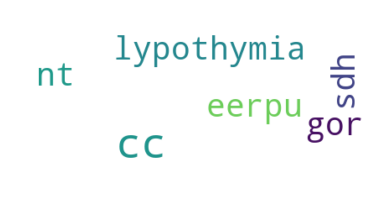


Cluster 2


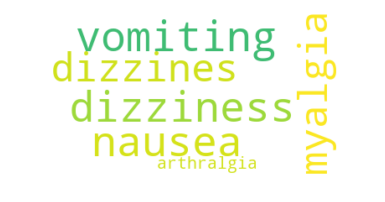


Cluster 3


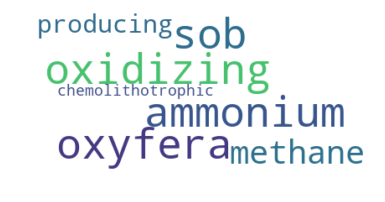


Cluster 4


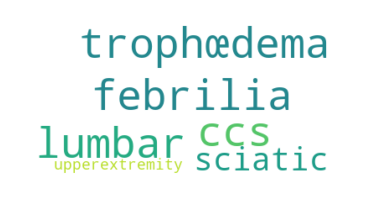


Cluster 5


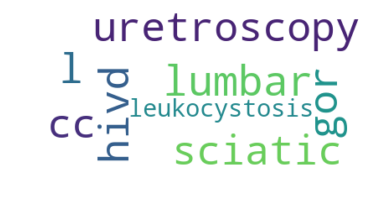


Cluster 6


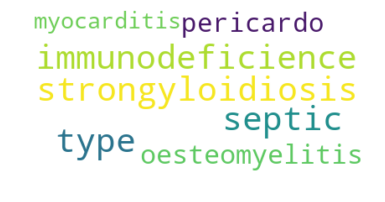


Cluster 7


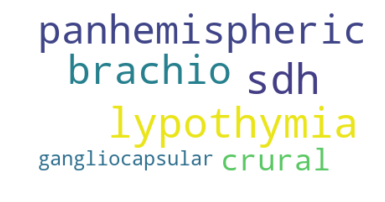


Cluster 8


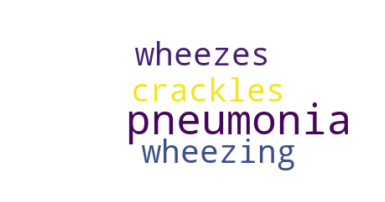


Cluster 9


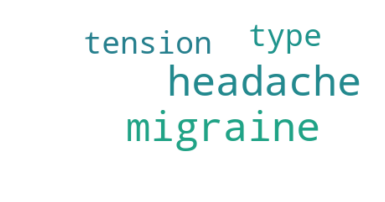


Cluster 10


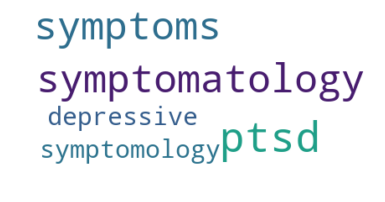


Cluster 11


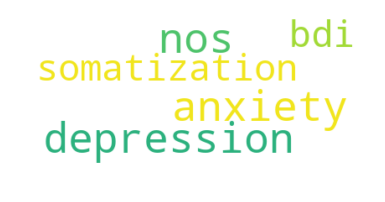


Cluster 12


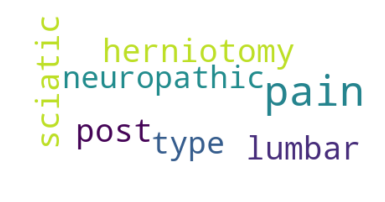


Cluster 13


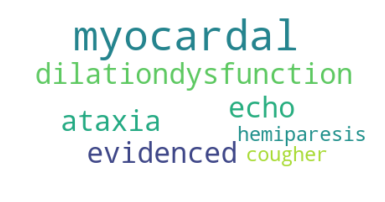


Cluster 14


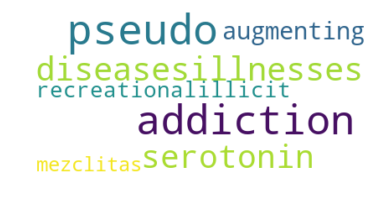

In [17]:
print("Top terms per cluster (based on centroids):")
for i in range(nb_clusters):
    tokens_per_cluster = ""
    most_representative = my_model.wv.most_similar(positive=[kmeans.cluster_centers_[i]], topn=5)
    text=""
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
        text += t[0]+" "
    text = text[:-1]
    print('\nCluster {}'.format(i))
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    # print('Titles')
    # titles=wiki_cl[wiki_cl.cluster==k]['title']         
    # print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [19]:
# Exemple Cluster 11 sur le problème cardiaque
result = np.where(lst == 5)
print(result)
for i in result[0] :
    print(df_con.loc[i,"filename"].split('/')[-1])

(array([  3,   4,   6,  22,  31,  33,  39,  41,  46,  51,  53,  56,  66,
        71,  80,  81,  88,  94, 101, 103, 105, 106, 108, 131, 132, 133,
       135, 136, 146, 158, 160, 162, 169], dtype=int64),)
record-108.con
record-109.con
record-122.con
record-178.con
record-25.con
record-27.con
record-33.con
record-35.con
record-46.con
record-51.con
record-53.con
record-56.con
record-73.con
record-83.con
105732749.con
115026438_SC.con
176746010_WGH.con
245317863_WGH.con
297228405_DH.con
320422564.con
333521954.con
337702516_WGH.con
348301810.con
598403789_DH.con
614746156.con
622086964.con
638157550_SC.con
641557794_WGH.con
779878634.con
891864133_RWH.con
915093496_RWH.con
920798564.con
989519730_WGH.con


In [45]:
# Exemple Cluster 11 sur le problème cardiaque
result = np.where(lst == 12)
print(result)
for i in result[0] :
    print(df_con.loc[i,"filename"].split('/')[-1])

(array([ 74, 113, 147], dtype=int64),)
026350193_RWH.con
402389409_WGH.con
788268693_DH.con


In [46]:
# Exemple Cluster 11 sur le problème cardiaque
result = np.where(lst == 13)
print(result)
for i in result[0] :
    print(df_con.loc[i,"filename"].split('/')[-1])

(array([  4,  19,  20,  30,  45,  52, 108, 164], dtype=int64),)
record-109.con
record-175.con
record-176.con
record-24.con
record-45.con
record-52.con
348301810.con
950452368.con
